In [1]:
import time
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np

In [2]:
import sage.all
from sage.graphs.graph import Graph

In [3]:
import sys
import os

In [4]:
script_dir = os.path.abspath('./algorithms/')
sys.path.append(script_dir)

In [5]:
import s_metaheuristics as sm
import interval_graph_check as igc

### Simulated annealing - plot

In [6]:
def plot_sa(G):

    print("Simulated annealing")
    print("\n")
    
    start_time = time.time()

    added_edges, G_min, values = sm.simulated_annealing(G, num_iters=20000)

    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print(f"Initial graph: {G.edges(labels=False)}")
    if added_edges is None:
        print("Initial graph is already an interval graph")
    else:
        print(f"Added edges: {added_edges}")
    print(f"Execution time: {elapsed_time:.4f} s")
    print("\n")

    # Plotting initial graph
    plot_G = G.plot(figsize=(8, 8), vertex_size=500, edge_color='blue', graph_border=False)

    # Plotting modified graph
    if added_edges is None:
        plot_G_min = G.plot(figsize=(8, 8), vertex_size=500, edge_color='blue', graph_border=False)
    else:
        plot_G_min = G_min.plot(figsize=(8, 8), vertex_size=500, edge_color='red', graph_border=False)

    # Create figure and subplots
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    # Adding graphs to subplots
    plot_G.matplotlib(figure=fig, sub=axes[0])
    axes[0].set_title("Initial Graph")
    axes[0].axis('off')

    plot_G_min.matplotlib(figure=fig, sub=axes[1])
    axes[1].set_title("Modified Graph")
    axes[1].axis('off')

    # Plotting the solution values after the algorithm completes
    if values and any(val is not None for val in values):
        # Remove None values and plot
        clean_values = [val if val is not None else 0 for val in values]
        axes[2].plot(range(len(clean_values)), clean_values)
        axes[2].set_title('Simulated Annealing Progress')
        axes[2].set_xlabel('Steps')
        axes[2].set_ylabel('Solution Value')
        axes[2].set_ylim(bottom=0)  # Ensure y-axis starts from 0
    else:
        # Plot a horizontal line at y=0
        axes[2].axhline(y=0, color='black', linestyle='--')
        axes[2].set_title('Simulated Annealing Progress (No Added Edges)')
        axes[2].set_xlabel('Steps')
        axes[2].set_ylabel('Solution Value')
        axes[2].set_ylim(bottom=0)  # Ensure y-axis starts from 0

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

### Simulated annealing - cooling plot

In [7]:
cooling_params = {
    't_max_values' : [1000, 5000],
    't_min' : 1,
    'step_max' : 20000,
    'alpha' : 0.95
}

In [8]:
def plot_sa_cooling(G, cooling_params):
    
    print("Simulated annealing - cooling")
    print("\n")
    
    cooling_methods = {
        'linear_multiplicative': sm.linear_multiplicative_cooling,
        'natural_log_exponential_multiplicative': sm.natural_log_exponential_multiplicative_cooling,
        'logarithmic_multiplicative': sm.logarithmic_multiplicative_cooling,
        'quadratic_multiplicative': sm.quadratic_multiplicative_cooling,
        'linear_additive': sm.linear_additive_cooling,
        'exponential_additive': sm.exponential_additive_cooling,
        'quadratic_additive': sm.quadratic_additive_cooling
    }

    t_max_values = cooling_params['t_max_values']
    t_min = cooling_params['t_min']
    step_max = cooling_params['step_max']
    alpha = cooling_params['alpha']

    acceptance_rates = {t_max: [] for t_max in t_max_values}
    labels = list(cooling_methods.keys())
    colors = plt.cm.viridis(np.linspace(0, 1, len(t_max_values)))  # Use a colormap to get distinct colors

    check, _ = igc.check_interval_graph(G)
    if check:
        print('Graph is already interval graph')
    else:
        # Prepare plots
        fig, axs = plt.subplots(len(cooling_methods), len(t_max_values), figsize=(15, 15), sharex=True)
        fig.suptitle('Simulated Annealing Performance for Different Cooling Methods and Temperatures')

        for i, (name, cooling_func) in enumerate(cooling_methods.items()):
            for j, t_max in enumerate(t_max_values):
                
                start_time = time.time()
                
                best_state, G_minimal, values, best_energy, acceptance_rate = sm.simulated_annealing_cooling(
                    G, cooling_func, t_max=t_max, t_min=t_min, step_max=step_max, alpha=alpha
                )

                end_time = time.time()
                elapsed_time = end_time - start_time
                
                # Replace 'inf' values with NaN for plotting
                values = [v if v != float('inf') else np.nan for v in values]

                # Store acceptance rate for the current t_max
                acceptance_rates[t_max].append(acceptance_rate)

                # Print the best number of added edges
                print(f"Cooling Method: {name}")
                print(f't_max={t_max}, Best Number of Added Edges: {best_energy}, Acceptance rate: {acceptance_rate}')
                print(f"Execution time: {elapsed_time:.4f} s")
                print("-------------------------------")

                # Plot number of added edges
                ax = axs[i, j]
                ax.scatter(range(len(values)), values, color=colors[j], label=f't_max={t_max}')  # Scatter plot to handle NaN values
                ax.set_title(f'{name}')
                ax.set_xlabel('Step')
                ax.set_ylabel('Number of Added Edges')
                ax.legend()

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

        # Plotting the acceptance rates as grouped bar charts
        fig, ax = plt.subplots(figsize=(15, 8))  # Increased the size of the plot

        # Define width of bars and positions for each group
        bar_width = 0.05
        positions = np.arange(len(t_max_values))

        # Hatch patterns for inf values
        hatches = ['//', '\\\\', '||', '++', 'xx', 'oo', '--']

        tolerance = 1e-10  # Define a small tolerance

        # Plot each cooling method's acceptance rates
        for i, name in enumerate(labels):
            rates = [acceptance_rates[t_max][i] for t_max in t_max_values]
            colors = [f'C{i}' for _ in t_max_values]  # Assign colors to each bar based on cooling method index
            for j, rate in enumerate(rates):
                if abs(rate) < tolerance:
                    # If rate is effectively zero, plot with hatch pattern
                    ax.bar(positions[j] + i * bar_width, 1.0, bar_width, color=colors[j], hatch=hatches[i], label=name if j == 0 else "")
                else:
                    ax.bar(positions[j] + i * bar_width, rate, bar_width, color=colors[j], label=name if j == 0 else "")

        # Add a horizontal line at 0.8 acceptance rate
        ax.axhline(y=0.8, color='red', linestyle='--', label='0.8 Acceptance Rate')

        # Add labels and title
        ax.set_xlabel('t_max values')
        ax.set_ylabel('Acceptance Rate')
        ax.set_title('Acceptance Rates for Different Cooling Methods and t_max')
        ax.set_xticks(positions + bar_width * (len(labels) - 1) / 2)
        ax.set_xticklabels(t_max_values)
        ax.legend()

        plt.tight_layout()
        plt.show()

#### Testing on random graph

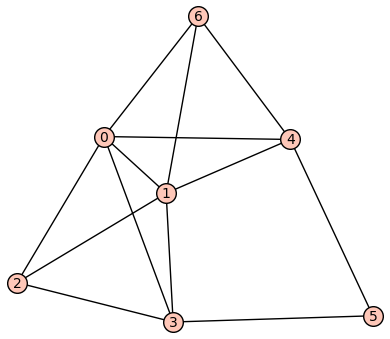

Simulated annealing


Initial graph: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 6), (1, 2), (1, 3), (1, 4), (1, 6), (2, 3), (3, 5), (4, 5), (4, 6)]
Added edges: [(3, 4)]
Execution time: 4.6631 s




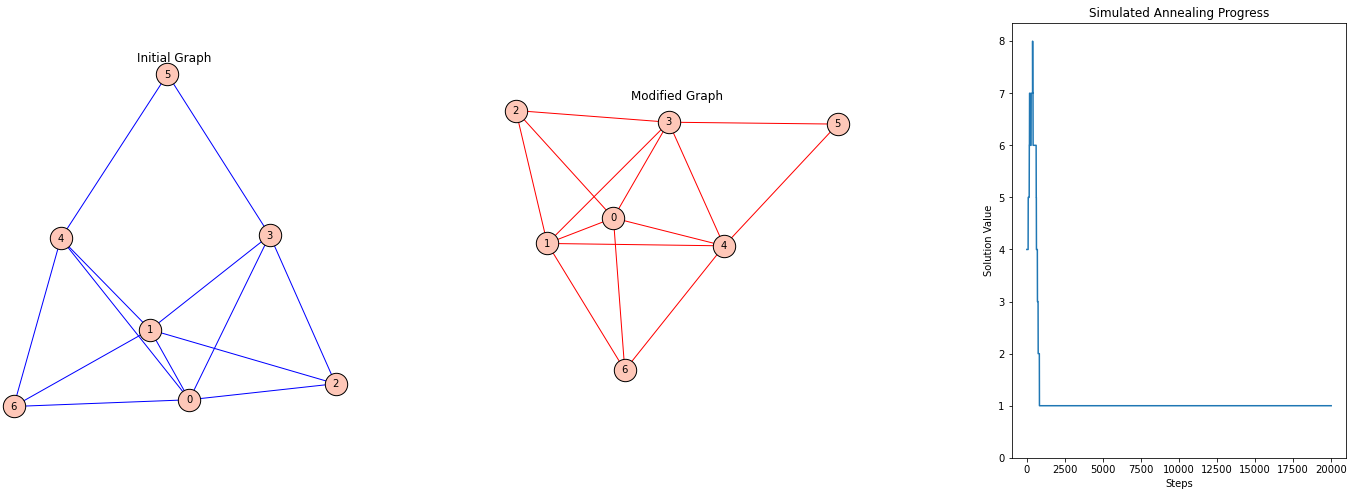

Simulated annealing - cooling


Cooling Method: linear_multiplicative
t_max=1000, Best Number of Added Edges: 1, Acceptance rate: 0.9753086419753086
Execution time: 0.3652 s
-------------------------------
Cooling Method: linear_multiplicative
t_max=5000, Best Number of Added Edges: 1, Acceptance rate: 0.9635258358662614
Execution time: 1.7419 s
-------------------------------
Cooling Method: natural_log_exponential_multiplicative
t_max=1000, Best Number of Added Edges: 1, Acceptance rate: 0.9044117647058824
Execution time: 0.0456 s
-------------------------------
Cooling Method: natural_log_exponential_multiplicative
t_max=5000, Best Number of Added Edges: 1, Acceptance rate: 0.9107142857142857
Execution time: 0.0569 s
-------------------------------
Cooling Method: logarithmic_multiplicative
t_max=1000, Best Number of Added Edges: 1, Acceptance rate: 0.63605
Execution time: 6.6277 s
-------------------------------
Cooling Method: logarithmic_multiplicative
t_max=5000, Best Number of 

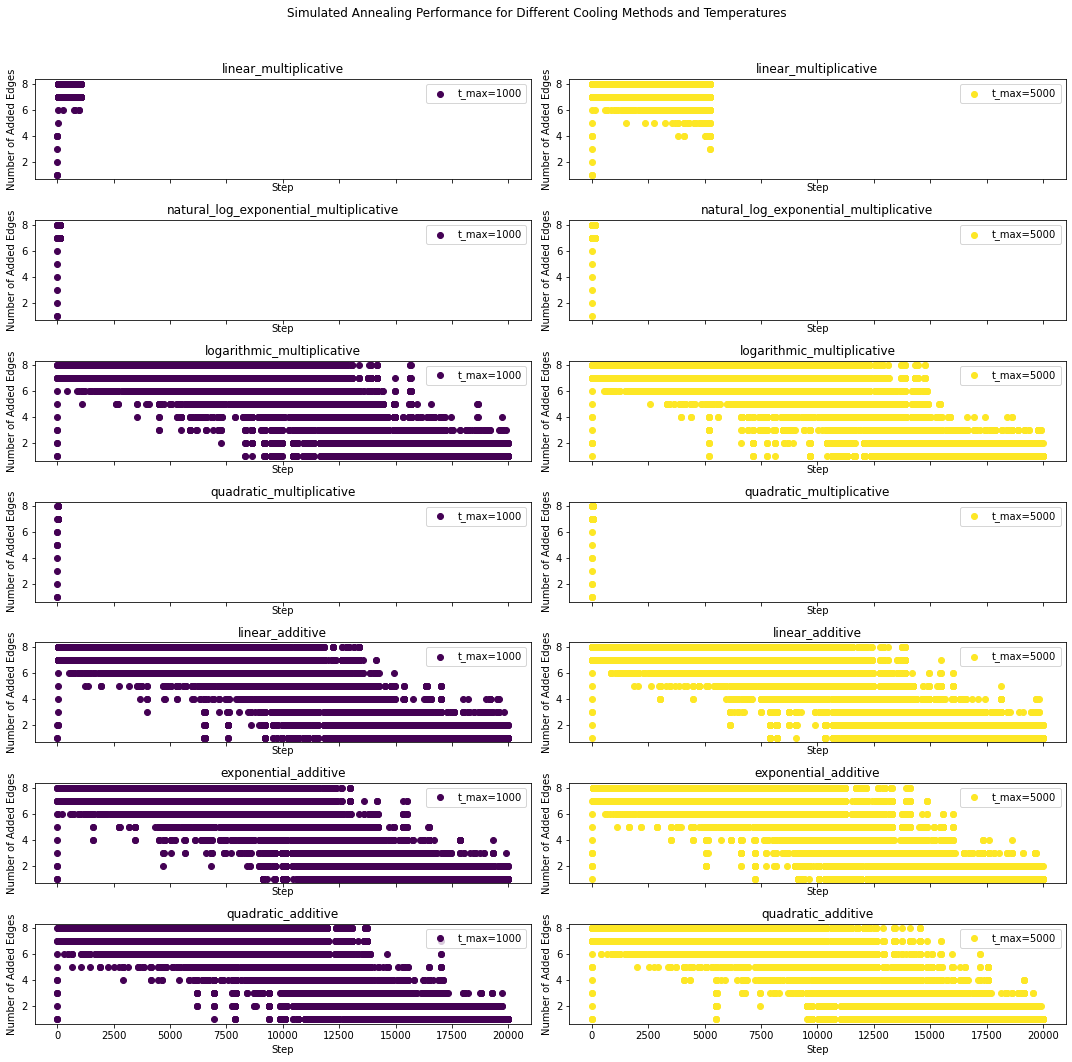

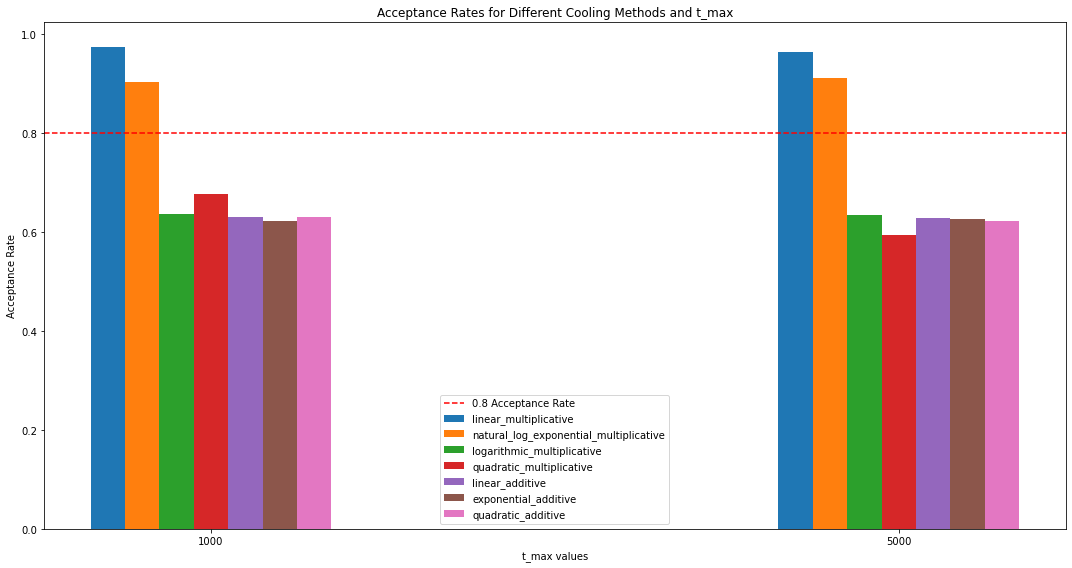

In [9]:
n = 7  # Number of vertices
p = 0.6  # Probability of edge creation

G = graphs.RandomGNP(n, p)
while not G.is_connected():
    G = graphs.RandomGNP(n, p)

G.show()

plot_sa(G)


plot_sa_cooling(G, cooling_params)